# MIMO OFDM Transmissions over the CDL Channel Model
In this notebook, you will learn how to setup a realistic simulation of a MIMO
point-to-point link between a mobile user terminal (UT) and a base station (BS).
Both, uplink and downlink directions are considered.
Here is a schematic diagram of the system model with all required components:

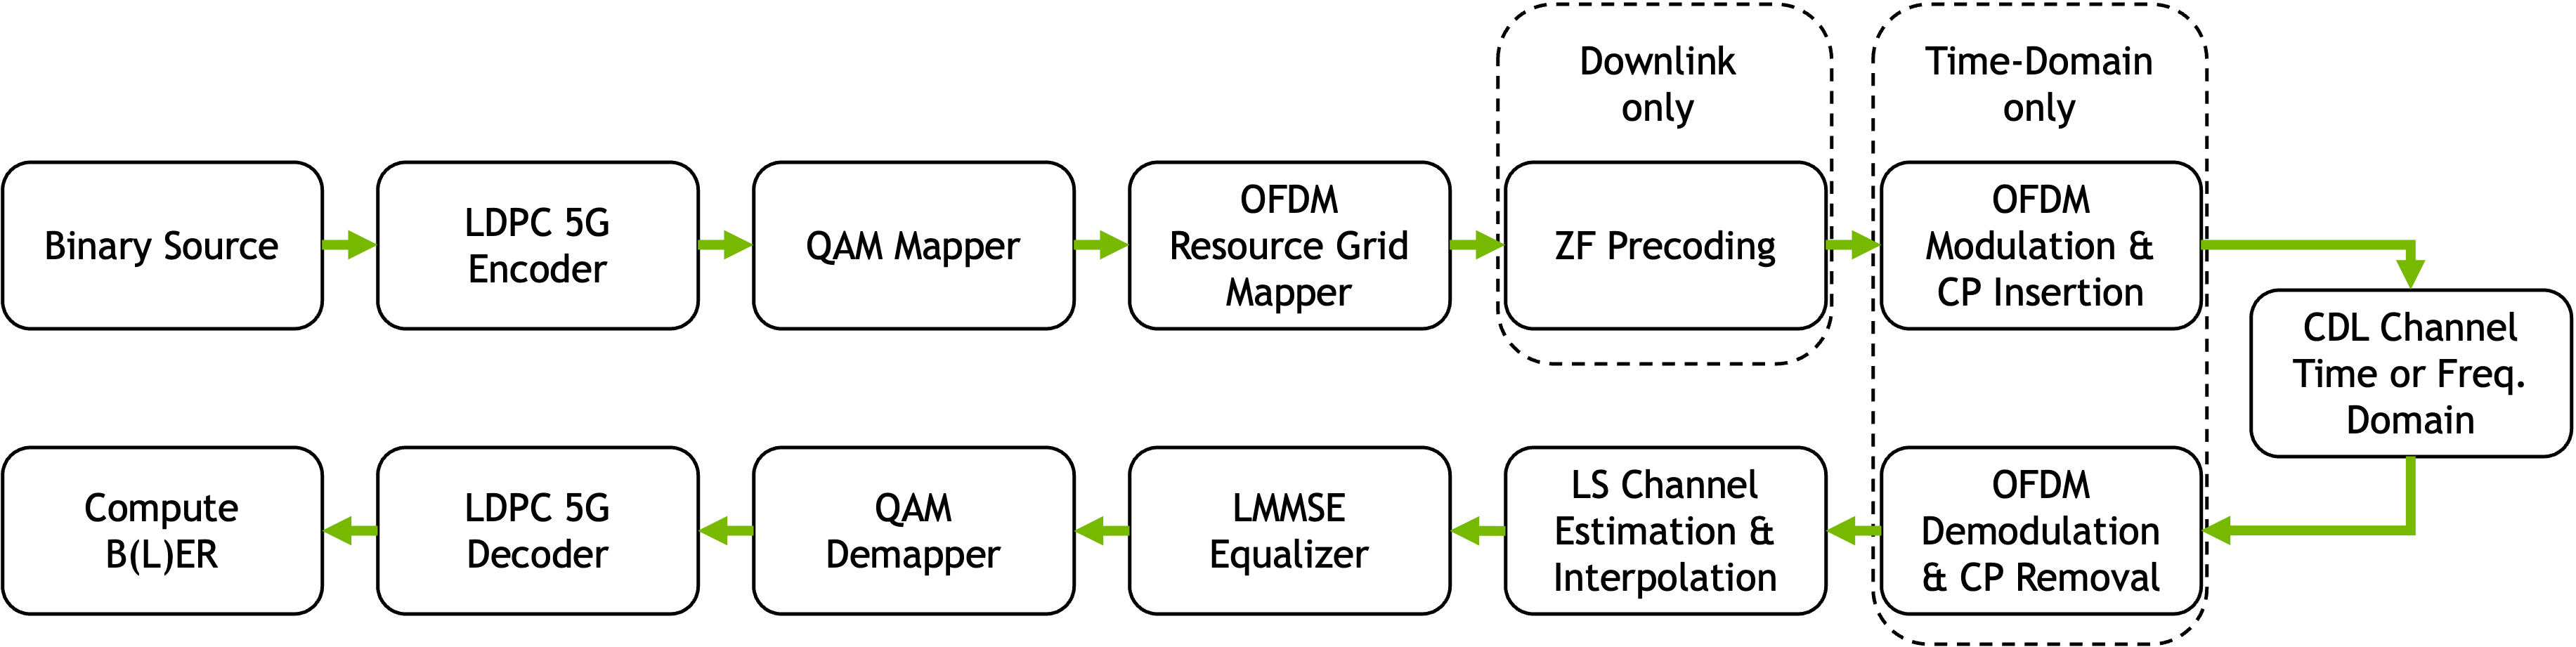


The setup includes:

* 5G LDPC FEC
* QAM modulation
* OFDM resource grid with configurabel pilot pattern
* Multiple data streams
* 3GPP 38.901 CDL channel models and antenna patterns
* ZF Precoding with perfect channel state information
* LS Channel estimation with nearest-neighbor interpolation as well as perfect CSI
* LMMSE MIMO equalization

You will learn how to simulate the channel in the time and frequency domains
and understand when to use which option.

In particular, you will investigate:

* The performance over different CDL models
* The impact of imperfect CSI
* Channel aging due to mobility
* Inter-symbol interference due to insufficient cyclic prefix length

We will first walk through the configuration of all components of the system model, before simulating
some simple transmissions in the time and frequency domain.
Then, we will build a general Keras model which will allow us to run efficiently simulations with different
parameter settings.

This is a notebook demonstrating a fairly advanced use of the Sionna library.
It is recommended that you familiarize yourself with the API documentation of the [Channel](https://nvlabs.github.io/sionna/api/channel.html) module and understand the difference between time- and frequency-domain modeling. Some of the simulations
take some time, especially when you have no GPU available. For this reason, we provide the simulation
results within the cells generating the figures. If you want to visualize your own results, just comment
the corresponding line.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [System Setup](#System-Setup)
    * [Stream Management](#Stream-Management)
    * [OFDM Resource Grid & Pilot Pattern](#OFDM-Resource-Grid-&-Pilot-Pattern)
    * [Antenna Arrays](#Antenna-Arrays)
    * [CDL Channel Model](#CDL-Channel-Model)
        * [CIR Sampling Process](#CIR-Sampling-Process)
        * [Generate the Channel Frequency Response](#Generate-the-Channel-Frequency-Response)
        * [Generate the Discrete-Time Channel Impulse Response](#Generate-the-Discrete-Time-Channel-Impulse-Response)
    * [Other Physical Layer Components](#Other-Physical-Layer-Components)
* [Simulations](#Simulations)
    * [Uplink Transmission in the Frequency Domain](#Uplink-Transmission-in-the-Frequency-Domain)
    * [Uplink Transmission in the Time Domain](#Uplink-Transmission-in-the-Time-Domain)
    * [Downlink Transmission in the Frequency Domain](#Downlink-Transmission-in-the-Frequency-Domain)
    * [Understand the Difference Between the CDL Models](#Understand-the-Difference-Between-the-CDL-Models)
    * [Create an End-to-End Keras Model](#Create-an-End-to-End-Keras-Model)
    * [Compare Uplink Performance Over Different CDL Models](#Compare-Uplink-Performance-Over-the-Different-CDL-Models)
    * [Compare Downlink Performance Over Different CDL Models](#Compare-Downlink-Performance-Over-the-Different-CDL-Models)
    * [Evaluate the Impact of Mobility](#Evaluate-the-Impact-of-Mobility)
    * [Evaluate the Impact of Insufficient Cyclic Prefix Length](#Evaluate-the-Impact-of-Insufficient-Cyclic-Prefix-Length)

### GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 0 used.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import AntennaArray, CDL, Antenna
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.utils.metrics import compute_ber

## System Setup <a class="anchor" id="System-Setup"></a>

We will now configure all components of the system model step-by-step.

### Stream Management <a class="anchor" id="Stream-Management"></a>

For any type of MIMO simulations, it is useful to setup a [StreamManagement](https://nvlabs.github.io/sionna/api/mimo.html#stream-management) object.
It determines which transmitters and receivers communicate data streams with each other.
In our scenario, we will configure a single UT and BS with multiple antennas each.
Whether the UT or BS is considered as a transmitter depends on the `direction`, which can be
either uplink or downlink. The [StreamManagement](https://nvlabs.github.io/sionna/api/mimo.html#stream-management) has many properties that are used by other components,
such as precoding and equalization.

We will configure the system here such that the number of streams per transmitter (in both uplink and donwlink)
is equal to the number of UT antennas.

In [3]:
# Define the number of UT and BS antennas.
# For the CDL model, that will be used in this notebook, only
# a single UT and BS are supported.
num_ut = 1
num_bs = 1
num_ut_ant = 4
num_bs_ant = 8

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
num_streams_per_tx = num_ut_ant

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

### OFDM Resource Grid & Pilot Pattern <a class="anchor" id="OFDM-Resource-Grid-&-Pilot-Pattern"></a>

Next, we configure an OFDM [ResourceGrid](https://nvlabs.github.io/sionna/api/ofdm.html#resource-grid) spanning multiple OFDM symbols.
The resource grid contains data symbols and pilots and is equivalent to a
*slot* in 4G/5G terminology. Although it is not relevant for our simulation, we null the DC subcarrier
and a few guard carriers to the left and right of the spectrum. Also a cyclic prefix is added.

During the creation of the [ResourceGrid](https://nvlabs.github.io/sionna/api/ofdm.html#resource-grid), a [PilotPattern](https://nvlabs.github.io/sionna/api/ofdm.html#pilot-pattern) is automatically generated.
We could have alternatively created a [PilotPattern](https://nvlabs.github.io/sionna/api/ofdm.html#pilot-pattern) first and then provided it as initialization parameter.

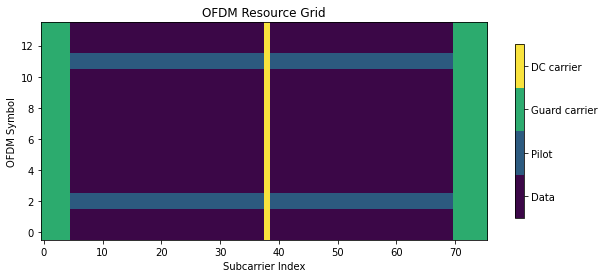

In [4]:
rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=76,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=6,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])
rg.show();

As can be seen in the figure above, the resource grid spans 76 subcarriers over 14 OFDM symbols. A DC guard carrier as well as some guard carriers to the left and right of the spectrum are nulled. The third and twelfth OFDM symbol are dedicated to pilot transmissions. 

Let us now have a look at the pilot pattern used by the transmitter. 

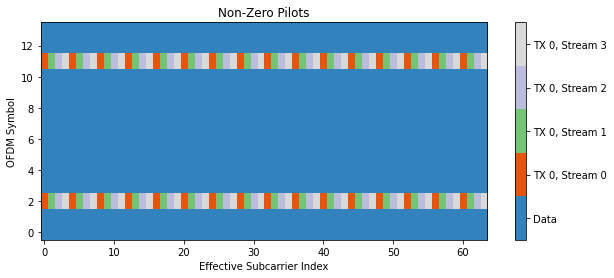

In [5]:
rg.pilot_pattern.show();

The pilot patterns are defined over the resource grid of *effective subcarriers* from which the nulled DC and guard carriers have been removed. This leaves us in our case with 76 - 1 (DC) - 5 (left guards) - 6 (right guards) = 64 effective subcarriers.

While the resource grid only knows which resource elements are reserved for pilots, it is the pilot pattern that defines what is actually transmitted on them. In our scenario, we have four transmit streams and configured the [KroneckerPilotPattern](https://nvlabs.github.io/sionna/api/ofdm.html#kroneckerpilotpattern). All streams use orthogonal pilot sequences, i.e., one pilot on every fourth subcarrier. You have full freedom to configure your own [PilotPattern](https://nvlabs.github.io/sionna/api/ofdm.html#pilotpattern).

Let us now have a look at the actual pilot sequences for all streams which consists of random QPSK symbols.
By default, the pilot sequences are normalized, such that the average power per pilot symbol is
equal to one. As only every fourth pilot symbol in the sequence is used, their amplitude is scaled by a factor of two.

Average energy per pilot symbol: 1.00


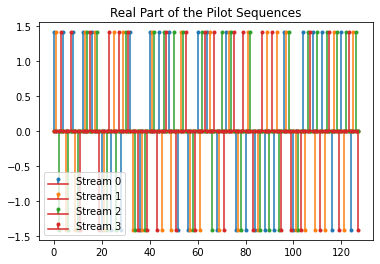

In [6]:
plt.figure()
plt.title("Real Part of the Pilot Sequences")
for i in range(num_streams_per_tx):
    plt.stem(np.real(rg.pilot_pattern.pilots[0, i]),
             markerfmt="C{}.".format(i), linefmt="C{}-".format(i),
             label="Stream {}".format(i))
plt.legend()
print("Average energy per pilot symbol: {:1.2f}".format(np.mean(np.abs(rg.pilot_pattern.pilots[0,0])**2)))

### Antenna Arrays <a class="anchor" id="Antenna-Arrays"></a>

Next, we need to configure the antenna arrays used by the UT and BS.
This can be ignored for simple channel models, such as [AWGN](https://nvlabs.github.io/sionna/api/channel.html#awgn), [flat-fading](https://nvlabs.github.io/sionna/api/channel.html#flat-fading-channel), [RayleighBlockFading](https://nvlabs.github.io/sionna/api/channel.html#rayleigh-block-fading), or [TDL](https://nvlabs.github.io/sionna/api/channel.html#tapped-delay-line-tdl) which do not account for antenna array geometries and antenna radiation patterns. However, other models, such as [CDL](https://nvlabs.github.io/sionna/api/channel.html#clustered-delay-line-cdl), [UMi](https://nvlabs.github.io/sionna/api/channel.html#urban-microcell-umi), [UMa](https://nvlabs.github.io/sionna/api/channel.html#urban-macrocell-uma), and [RMa](https://nvlabs.github.io/sionna/api/channel.html#rural-macrocell-rma) from the 3GPP 38.901 specification, require it.

We will assume here that UT and BS antenna arrays are composed of dual cross-polarized antenna elements with an antenna pattern defined in the 3GPP 38.901 specification. By default, the antenna elements are spaced half of a wavelength apart in both vertical and horizontal directions. You can define your own antenna geometries an radiation patterns if needed.

An [AntennaArray](https://nvlabs.github.io/sionna/api/channel.html#antennaarray) is always defined in the y-z plane. It's final orientation will be determined by the orientation of the UT or BS. This parameter can be configured in the [ChannelModel](https://nvlabs.github.io/sionna/api/channel.html#channel-model-interface) that we will create later.

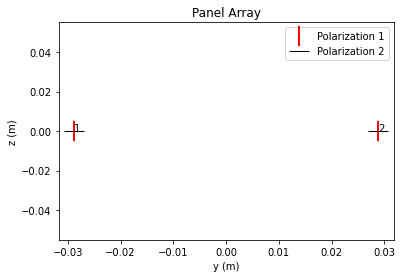

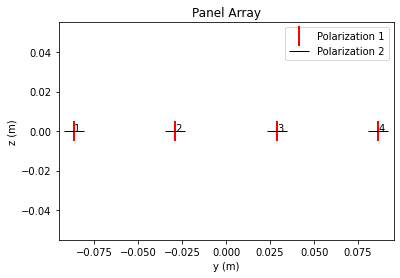

In [7]:
carrier_frequency = 2.6e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

ut_array = AntennaArray(num_rows=1,
                        num_cols=int(num_ut_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
ut_array.show()

bs_array = AntennaArray(num_rows=1,
                        num_cols=int(num_bs_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
bs_array.show()

We can also visualize the radiation pattern of an individual antenna element:

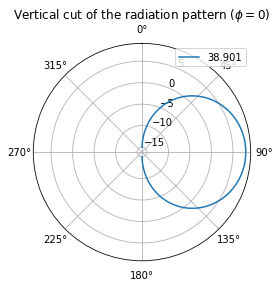

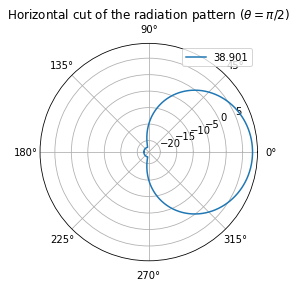

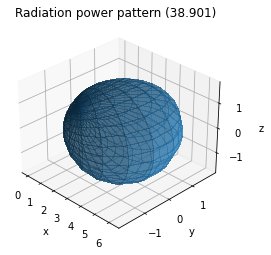

In [8]:
ut_array.show_element_radiation_pattern()

### CDL Channel Model <a class="anchor" id="CDL-Channel-Model"></a>

Now, we will create an instance of the CDL channel model.

In [9]:
delay_spread = 300e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value. 

direction = "uplink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.
cdl_model = "B"       # Suitable values are ["A", "B", "C", "D", "E"]

speed = 10            # UT speed [m/s]. BSs are always assumed to be fixed.
                      # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
# cdl() will generate CIRs that can be converted to discrete time or discrete frequency.
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)

#### CIR Sampling Process <a class="anchor" id="CIR-Sampling-Process"></a>

The instance `cdl` of the [CDL](https://nvlabs.github.io/sionna/api/channel.html#clustered-delay-line-cdl) [ChannelModel](https://nvlabs.github.io/sionna/api/channel.html#channel-model-interface) can be used to generate batches of random realizations of continuous-time
channel impulse responses, consisting of complex gains `a` and delays `tau` for each path. 
To account for time-varying channels, a channel impulse responses is sampled at the `sampling_frequency` for `num_time_samples` samples.
For more details on this, please have a look at the [API documentation](https://nvlabs.github.io/sionna/api/channel.html) of the channel models.

In order to model the channel in the frequency domain, we need `num_ofdm_symbols` samples that are taken once per `ofdm_symbol_duration`, which corresponds to the length of an OFDM symbol plus the cyclic prefix.

In [10]:
a, tau = cdl(batch_size=32, num_time_steps=rg.num_ofdm_symbols, sampling_frequency=1/rg.ofdm_symbol_duration)

The path gains `a` have shape\
`[batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]`\
and the delays `tau` have shape\
`[batch_size, num_rx, num_tx, num_paths]`.

In [11]:
print("Shape of the path gains: ", a.shape)
print("Shape of the delays:", tau.shape)

Shape of the path gains:  (32, 1, 8, 1, 4, 23, 14)
Shape of the delays: (32, 1, 1, 23)


The delays are assumed to be static within the time-window of interest. Only the complex path gains change over time.
The following two figures depict the channel impulse response at a particular time instant and the time-evolution of the gain of one path, respectively.

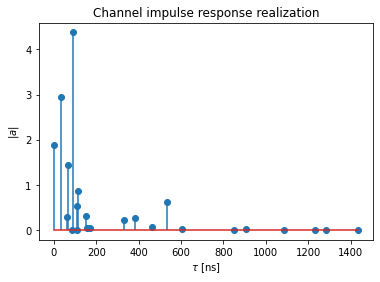

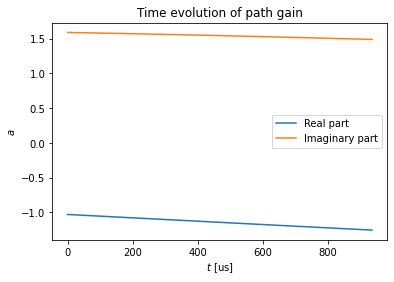

In [12]:
plt.figure()
plt.title("Channel impulse response realization")
plt.stem(tau[0,0,0,:]/1e-9, np.abs(a)[0,0,0,0,0,:,0])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")


plt.figure()
plt.title("Time evolution of path gain")
plt.plot(np.arange(rg.num_ofdm_symbols)*rg.ofdm_symbol_duration/1e-6, np.real(a)[0,0,0,0,0,0,:])
plt.plot(np.arange(rg.num_ofdm_symbols)*rg.ofdm_symbol_duration/1e-6, np.imag(a)[0,0,0,0,0,0,:])
plt.legend(["Real part", "Imaginary part"])

plt.xlabel(r"$t$ [us]")
plt.ylabel(r"$a$");

#### Generate the Channel Frequency Response <a class="anchor" id="Generate-the-Channel-Frequency-Response"></a>

If we want to use the continuous-time channel impulse response to simulate OFDM transmissions
under ideal conditions, i.e., no inter-symbol interference, inter-carrier interference, etc.,
we need to convert it to the frequency domain. 

This can be done with the function [cir_to_ofdm_channel](https://nvlabs.github.io/sionna/api/channel.html#cir-to-ofdm-channel) that computes the Fourier transform of the
continuous-time channel impulse response at a set of `frequencies`, corresponding to the
different subcarriers. The frequencies can be obtained with the help of the convenience function
[subcarrier_frequencies](https://nvlabs.github.io/sionna/api/channel.html#subcarrier-frequencies).

In [13]:
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)

Let us have a look at the channel frequency response at a given time instant:

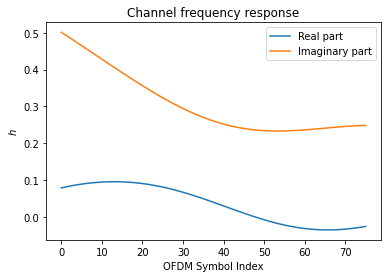

In [14]:
plt.figure()
plt.title("Channel frequency response")
plt.plot(np.real(h_freq[0,0,0,0,0,0,:]))
plt.plot(np.imag(h_freq[0,0,0,0,0,0,:]))
plt.xlabel("OFDM Symbol Index")
plt.ylabel(r"$h$")
plt.legend(["Real part", "Imaginary part"]);

We can apply the channel frequency response to a given input with the [ApplyOFDMChannel](https://nvlabs.github.io/sionna/api/channel.html#applyofdmchannel) layer. This layer can also add additive white Gaussian noise (AWGN) to the channel output.

In [15]:
# Function that will apply the channel frequency response to an input signal
channel_freq = ApplyOFDMChannel(add_awgn=True)

#### Generate the Discrete-Time Channel Impulse Response <a class="anchor" id="Generate-the-Discrete-Time-Channel-Impulse-Response"></a>

In the same way as we have created the frequency channel impulse response from the continuous-time
response, we can use the latter to compute a discrete-time impulse response. This can then be used
to model the channel in the time-domain through discrete convolution with an input signal.
Time-domain channel modeling is necessary whenever we want to deviate from the perfect OFDM scenario,
e.g., OFDM without cyclic prefix, inter-subcarrier interference due to carrier-frequency offsets,
phase noise, or very high Doppler spread scenarios, as well as other single or multicarrier waveforms
(OTFS, FBMC, UFMC, etc).

A discrete-time impulse response can be obtained with the help of the function [cir_to_time_channel](https://nvlabs.github.io/sionna/api/channel.html#cir-to-time-channel)
that requires a `bandwidth` parameter. This function first applies a perfect low-pass filter of
the provided `bandwith` to the continuous-time channel impulse response and then samples the filtered
response at the Nyquist rate. The resulting  discrete-time impulse response is then truncated to
finite length, depending on the delay spread. `l_min` and `l_max` denote truncation boundaries and the
resulting channel has `l_tot=l_max-l_min+1` filter taps. A detailed mathematical description of this process
is provided in the API documentation of the channel models. You can freely chose both parameters if you
do not want to rely on the default values.

In order to model the channel in the domain, the continuous-time channel impulse response must be sampled
at the Nyquist rate. We also need now `num_ofdm_symbols x (fft_size + cyclic_prefix_length) + l_tot-1` samples
in contrast to `num_ofdm_symbols` samples for modeling in the frequency domain. This implies that the 
memory requirements of time-domain channel modeling is significantly higher. We therefore
recommend to only use this feature if it is really necessary. Simulations with many transmitters, receivers,
and/or large antenna arrays become otherwise quickly prohibitively complex.

In [16]:
# The following values for truncation are recommended.
# Please feel free to tailor them to you needs.
l_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)
l_tot = l_max-l_min+1

a, tau = cdl(batch_size=2, num_time_steps=rg.num_time_samples+l_tot-1, sampling_frequency=rg.bandwidth)

In [17]:
h_time = cir_to_time_channel(rg.bandwidth, a, tau, l_min=l_min, l_max=l_max, normalize=True)

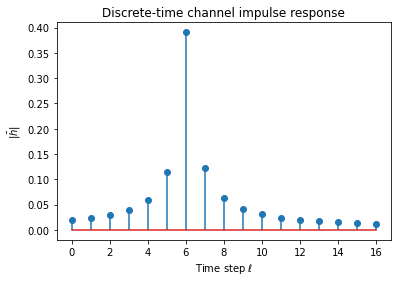

In [18]:
plt.figure()
plt.title("Discrete-time channel impulse response")
plt.stem(np.abs(h_time[0,0,0,0,0,0]))
plt.xlabel(r"Time step $\ell$")
plt.ylabel(r"$|\bar{h}|$");

We can apply the discrete-time impulse response to a given input with the [ApplyTimeChannel](https://nvlabs.github.io/sionna/api/channel.html#applytimechannel) layer. This layer can also add additive white Gaussian noise (AWGN) to the channel output.

In [19]:
# Function that will apply the discrete-time channel impulse response to an input signal
channel_time = ApplyTimeChannel(rg.num_time_samples, l_tot=l_tot, add_awgn=True)

### Other Physical Layer Components <a class="anchor" id="Other-Physical-Layer-Components"></a>

Finally, we create instances of all other physical layer components we need. Most of these layers are self-explanatory.
For more information, please have a look at the API documentation.

In [20]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.5 # Code rate
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# The zero forcing precoder precodes the transmit stream towards the intended antennas
zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

# OFDM modulator and demodulator
modulator = OFDMModulator(rg.cyclic_prefix_length)
demodulator = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

## Simulations <a class="anchor" id="Simulations"></a>

### Uplink Transmission in the Frequency Domain <a class="anchor" id="Uplink-Transmission-in-the-Frequency-Domain"></a>

Now, we will simulate our first uplink transmission! Inspect the code to understand how perfect CSI at the receiver can be simulated.

In [21]:
batch_size = 32 # Depending on the memory of your GPU (or system when a CPU is used),
                # you can in(de)crease the batch size. The larger the batch size, the
                # more memory is required. However, simulations will also run much faster.
ebno_db = 40
perfect_csi = False # Change to switch between perfect and imperfect CSI

# Compute the noise power for a given Eb/No value.
# This takes not only the coderate but also the overheads related pilot
# transmissions and nulled carriers
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)

b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)

# As explained above, we generate random batches of CIR, transform them
# in the frequency domain and apply them to the resource grid in the
# frequency domain.
cir = cdl(batch_size, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
y = channel_freq([x_rg, h_freq, no])

if perfect_csi:
    # For perfect CSI, the receiver gets the channel frequency response as input
    # However, the channel estimator only computes estimates on the non-nulled
    # subcarriers. Therefore, we need to remove them here from `h_freq`.
    # This step can be skipped if no subcarriers are nulled. 
    h_hat, err_var = remove_nulled_scs(h_freq), 0.
else:
    h_hat, err_var = ls_est ([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))

BER: 0.0


An alternative approach to simulations in the frequency domain is to use the
convenience function [OFDMChannel](https://nvlabs.github.io/sionna/api/channel.html#ofdmchannel) that jointly generates and applies
the channel frequency response. Using this function, we could have used
the following code:

In [22]:
ofdm_channel = OFDMChannel(cdl, rg, add_awgn=True, normalize_channel=True, return_channel=True)
y, h_freq = ofdm_channel([x_rg, no])

### Uplink Transmission in the Time Domain <a class="anchor" id="Uplink-Transmission-in-the-Time-Domain"></a>

In the previous example, OFDM modulation/demodulation were not needed as the entire system was simulated
in the frequency domain. However, this modeling approach is not able to capture many realistic effects. 

With the following modifications, the system can be modeled in the time domain.

Have a careful look at how perfect CSI of the channel frequency response is simulated here.

In [23]:
batch_size = 4 # We pick a small batch_size as executing this code in Eager mode could consume a lot of memory
ebno_db = 30
perfect_csi = True

no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)
b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)

# The CIR needs to be sampled every 1/bandwith [s].
# In contrast to frequency-domain modeling, this implies
# that the channel can change over the duration of a single
# OFDM symbol. We now also need to simulate more
# time steps.
cir = cdl(batch_size, rg.num_time_samples+l_tot-1, rg.bandwidth)

# OFDM modulation with cyclic prefix insertion
x_time = modulator(x_rg)

# Compute the discrete-time channel impulse reponse
h_time = cir_to_time_channel(rg.bandwidth, *cir, l_min, l_max, normalize=True)

# Compute the channel output
# This computes the full convolution between the time-varying
# discrete-time channel impulse reponse and the discrete-time
# transmit signal. With this technique, the effects of an
# insufficiently long cyclic prefix will become visible. This
# is in contrast to frequency-domain modeling which imposes
# no inter-symbol interfernce.
y_time = channel_time([x_time, h_time, no])

# OFDM demodulation and cyclic prefix removal
y = demodulator(y_time)

if perfect_csi:
    
    a, tau = cir
    
    # We need to sub-sample the channel impulse reponse to compute perfect CSI
    # for the receiver as it only needs one channel realization per OFDM symbol
    a_freq = a[...,rg.cyclic_prefix_length:-1:(rg.fft_size+rg.cyclic_prefix_length)]
    a_freq = a_freq[...,:rg.num_ofdm_symbols]
    
    # Compute the channel frequency response
    h_freq = cir_to_ofdm_channel(frequencies, a_freq, tau, normalize=True)
   
    h_hat, err_var = remove_nulled_scs(h_freq), 0.
else:
    h_hat, err_var = ls_est ([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))

BER: 0.0


An alternative approach to simulations in the time domain is to use the
convenience function [TimeChannel](https://nvlabs.github.io/sionna/api/channel.html#timechannel) that jointly generates and applies
the discrete-time channel impulse response. Using this function, we could have used
the following code:

In [24]:
time_channel = TimeChannel(cdl, rg.bandwidth, rg.num_time_samples,
                           l_min=l_min, l_max=l_max, normalize_channel=True,
                           add_awgn=True, return_channel=True)

y_time, h_time = time_channel([x_time, no])

Next, we will compare the perfect CSI that we computed above using the ideal
channel frequency response and the estimated channel response that we obtain 
from pilots with nearest-neighbor interpolation based on simulated transmissions
in the time domain.

In [25]:
# In the example above, we assumed perfect CSI, i.e.,
# h_hat correpsond to the exact ideal channel frequency response.
h_perf = h_hat[0,0,0,0,0,0]

# We now compute the LS channel estimate from the pilots.
h_est, _ = ls_est ([y, no])
h_est = h_est[0,0,0,0,0,0]

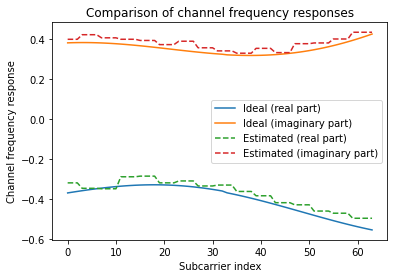

In [26]:
plt.figure()
plt.plot(np.real(h_perf))
plt.plot(np.imag(h_perf))
plt.plot(np.real(h_est), "--")
plt.plot(np.imag(h_est), "--")
plt.xlabel("Subcarrier index")
plt.ylabel("Channel frequency response")
plt.legend(["Ideal (real part)", "Ideal (imaginary part)", "Estimated (real part)", "Estimated (imaginary part)"]);
plt.title("Comparison of channel frequency responses");

### Downlink Transmission in the Frequency Domain <a class="anchor" id="Downlink-Transmission-in-the-Frequency-Domain"></a>

We will now simulate a simple downlink transmission in the frequency domain.
In contrast to the uplink, the transmitter is now assumed to precode independent data
streams to each antenna of the receiver based on perfect CSI.

The receiver can either estimate the channel or get access to the effective channel
after precoding.

The first thing to do, is to change the `direction` within the CDL model. This makes the BS the transmitter and the UT the receiver.

In [27]:
direction = "downlink"
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)

The following code shows the other necessary modifications:

In [28]:
perfect_csi = True # Change to switch between perfect and imperfect CSI
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)

b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)
cir = cdl(batch_size, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)

# Precode the transmit signal in the frequency domain
# It is here assumed that the transmitter has perfect knowledge of the channel
# One could here reduce this to perfect knowledge of the channel for the first
# OFDM symbol, or a noisy version of it to take outdated transmit CSI into account.
# `g` is the post-beamforming or `effective channel` that can be
# used to simulate perfect CSI at the receiver.
x_rg, g = zf_precoder([x_rg, h_freq])

y = channel_freq([x_rg, h_freq, no])

if perfect_csi:
    # The receiver gets here the effective channel after precoding as CSI
    h_hat, err_var = g, 0.
else:
    h_hat, err_var = ls_est ([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))

BER: 0.0


We do not explain here on purpose how to model the downlink transmission in the time domain
as it is a good exercise for the reader to do it her/himself. The key steps are:

* Sample the channel impulse response at the Nyquist rate.
* Downsample it to the OFDM symbol (+ cyclic prefix) rate (look at the uplink example).
* Convert the downsampled CIR to the frequency domain.
* Give this CSI to the transmitter for precoding.
* Convert the CIR to discrete-time to compute the channel output in the time domain.

### Understand the Difference Between the CDL Models <a class="anchor" id="Understand-the-Difference-Between-the-CDL-Models"></a>

Before we proceed with more advanced simulations, it is important to understand the differences
between the different CDL models. The models "A", "B", and "C" are non-line-of-sight (NLOS) models,
while "D" and "E" are LOS. In the following code snippet, we compute the empirical cummulative
distribution function (CDF) of the condition number of the channel frequency response matrix
between all receiver and transmit antennas.

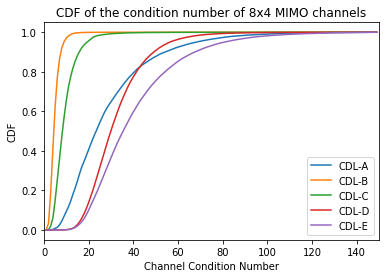

In [29]:
def fun(cdl_model):
    """Generates a histogram of the channel condition numbers"""
    
    # Setup a CIR generator
    cdl = CDL(cdl_model, delay_spread, carrier_frequency,
              ut_array, bs_array, "uplink", min_speed=0)
    
    # Generate random CIR realizations
    # As we nned only a single sample in time, the sampling_frequency
    # does not matter.
    cir = cdl(2000, 1, 1)
    
    # Compute the frequency response
    h = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
    
    # Reshape to [batch_size, fft_size, num_rx_ant, num_tx_ant]
    h = tf.squeeze(h)
    h = tf.transpose(h, [0,3,1,2])
    
    # Compute condition number
    c = np.reshape(np.linalg.cond(h), [-1])
    
    # Compute normalized histogram
    hist, bins = np.histogram(c, 150, (1, 150))
    hist = hist/np.sum(hist)
    return bins[:-1], hist

plt.figure()
for cdl_model in ["A", "B", "C", "D", "E"]:
    bins, hist = fun(cdl_model)
    plt.plot(bins, np.cumsum(hist))
plt.xlim([0,150])
plt.legend(["CDL-A", "CDL-B", "CDL-C", "CDL-D", "CDL-E"]);
plt.xlabel("Channel Condition Number")
plt.ylabel("CDF")
plt.title("CDF of the condition number of 8x4 MIMO channels");

From the figure above, you can observe that the CDL-B and CDL-C models
are substantially better conditioned than the other models. This makes 
them more suitable for MIMO transmissions as we will observe in the next
section.

### Create an End-to-End Keras Model <a class="anchor" id="Create-an-End-to-End-Keras-Model"></a>

For longer simulations, it is often convenient to pack all code into a single
Keras model that outputs batches of transmitted and received information bits
at a given Eb/No point. The following code defines a very general model that can
simulate uplink and downlink transmissions with time or frequency domain modeling
over the different CDL models. It allows to configure perfect or imperfect CSI,
UT speed, cyclic prefix length, and the number of OFDM symbols for pilot transmissions.

In [30]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True. 
sionna.config.xla_compat=True
class Model(tf.keras.Model):
    """This Keras model simulates OFDM MIMO transmissions over the CDL model.
    
    Simulates point-to-point transmissions between a UT and a BS.
    Uplink and downlink transmissions can be realized with either perfect CSI
    or channel estimation. ZF Precoding for downlink transmissions is assumed.
    The receiver (in both uplink and downlink) applies LS channel estimation
    and LMMSE MIMO equalization. A 5G LDPC code as well as QAM modulation are
    used.
    
    Parameters
    ----------
    domain : One of ["time", "freq"], str
        Determines if the channel is modeled in the time or frequency domain.
        Time-domain simulations are generally slower and consume more memory.
        They allow modeling of inter-symbol interference and channel changes
        during the duration of an OFDM symbol.
        
    direction : One of ["uplink", "downlink"], str
        For "uplink", the UT transmits. For "downlink" the BS transmits.
        
    cdl_model : One of ["A", "B", "C", "D", "E"], str
        The CDL model to use. Note that "D" and "E" are LOS models that are
        not well suited for the transmissions of multiple streams.
        
    delay_spread : float
        The nominal delay spread [s].
        
    perfect_csi : bool
        Indicates if perfect CSI at the receiver should be assumed. For downlink
        transmissions, the transmitter is always assumed to have perfect CSI.
      
    speed : float
        The UT speed [m/s].
        
    cyclic_prefix_length : int
        The length of the cyclic prefix in number of samples.
        
    pilot_ofdm_symbol_indices : list, int
        List of integers defining the OFDM symbol indices that are reserved
        for pilots.
        
    subcarrier_spacing : float
        The subcarrier spacing [Hz]. Defaults to 15e3. 
      
    Input
    -----
    batch_size : int
        The batch size, i.e., the number of independent Mote Carlo simulations
        to be performed at once. The larger this number, the larger the memory
        requiremens.
        
    ebno_db : float
        The Eb/No [dB]. This value is converted to an equivalent noise power
        by taking the modulation order, coderate, pilot and OFDM-related
        overheads into account.
        
    Output
    ------
    b : [batch_size, 1, num_streams, k], tf.float32
        The tensor of transmitted information bits for each stream.
        
    b_hat : [batch_size, 1, num_streams, k], tf.float32
        The tensor of received information bits for each stream.   
    """
    
    def __init__(self,
                 domain,
                 direction,
                 cdl_model,
                 delay_spread,
                 perfect_csi,
                 speed,
                 cyclic_prefix_length,
                 pilot_ofdm_symbol_indices,
                 subcarrier_spacing = 15e3 
                ):
        super().__init__()
        
        # Provided parameters
        self._domain = domain
        self._direction = direction
        self._cdl_model = cdl_model
        self._delay_spread = delay_spread
        self._perfect_csi = perfect_csi
        self._speed = speed
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        
        # System parameters
        self._carrier_frequency = 2.6e9
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = 72
        self._num_ofdm_symbols = 14
        self._num_ut_ant = 4 # Must be a multiple of two as dual-polarized antennas are used
        self._num_bs_ant = 8 # Must be a multiple of two as dual-polarized antennas are used
        self._num_streams_per_tx = self._num_ut_ant
        self._dc_null = True
        self._num_guard_carriers = [5, 6]
        self._pilot_pattern = "kronecker"
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._num_bits_per_symbol = 2 
        self._coderate = 0.5
          
        # Required system components
        self._sm = StreamManagement(np.array([[1]]), self._num_streams_per_tx)
        
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing = self._subcarrier_spacing,
                                num_tx=1,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                num_guard_carriers=self._num_guard_carriers,
                                dc_null=self._dc_null,
                                pilot_pattern=self._pilot_pattern,
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices) 
        
        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol)
        self._k = int(self._n * self._coderate) 
        
        self._ut_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_ut_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)
        
        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)
        
        self._cdl = CDL(model=self._cdl_model,
                        delay_spread=self._delay_spread,
                        carrier_frequency=self._carrier_frequency,
                        ut_array=self._ut_array,
                        bs_array=self._bs_array,
                        direction=self._direction,
                        min_speed=self._speed)
        
        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)
        
        if self._domain == "freq":  
            self._channel_freq = ApplyOFDMChannel(add_awgn=True)

        elif self._domain == "time":
            self._l_min, self._l_max = time_lag_discrete_time_channel(self._rg.bandwidth)
            self._l_tot = self._l_max - self._l_min + 1
            self._channel_time = ApplyTimeChannel(self._rg.num_time_samples,
                                                  l_tot=self._l_tot,
                                                  add_awgn=True)
            self._modulator = OFDMModulator(self._cyclic_prefix_length)
            self._demodulator = OFDMDemodulator(self._fft_size, self._l_min, self._cyclic_prefix_length)
               
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)
        
        if self._direction == "downlink":
            self._zf_precoder = ZFPrecoder(self._rg, self._sm, return_effective_channel=True)
       
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
        self._remove_nulled_scs = RemoveNulledSubcarriers(self._rg)

    @tf.function(jit_compile=True) # See the following guide: https://www.tensorflow.org/guide/function
    def call(self, batch_size, ebno_db):
        
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        b = self._binary_source([batch_size, 1, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
                  
        if self._domain == "time":
            # Time-domain simulations
            
            a, tau = self._cdl(batch_size, self._rg.num_time_samples+self._l_tot-1, self._rg.bandwidth)
            h_time = cir_to_time_channel(self._rg.bandwidth, a, tau,
                                         l_min=self._l_min, l_max=self._l_max, normalize=True)
            
            # As precoding is done in the frequency domain, we need to downsample
            # the path gains `a` to the OFDM symbol rate prior to converting the CIR
            # to the channel frequency response.
            a_freq = a[...,self._rg.cyclic_prefix_length:-1:(self._rg.fft_size+self._rg.cyclic_prefix_length)]
            a_freq = a_freq[...,:self._rg.num_ofdm_symbols]
            h_freq = cir_to_ofdm_channel(self._frequencies, a_freq, tau, normalize=True)
            
            if self._direction == "downlink":
                x_rg, g = self._zf_precoder([x_rg, h_freq])
            
            x_time = self._modulator(x_rg)
            y_time = self._channel_time([x_time, h_time, no])
            
            y = self._demodulator(y_time)
            
        elif self._domain == "freq":
            # Frequency-domain simulations
            
            cir = self._cdl(batch_size, self._rg.num_ofdm_symbols, 1/self._rg.ofdm_symbol_duration)
            h_freq = cir_to_ofdm_channel(self._frequencies, *cir, normalize=True)
            
            if self._direction == "downlink":
                x_rg, g = self._zf_precoder([x_rg, h_freq])
            
            y = self._channel_freq([x_rg, h_freq, no])
        
        if self._perfect_csi:
            if self._direction == "uplink":
                h_hat = self._remove_nulled_scs(h_freq)
            elif self._direction =="downlink":
                h_hat = g
            err_var = 0.0            
        else:
            h_hat, err_var = self._ls_est ([y, no])
        
        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        llr = self._demapper([x_hat, no_eff])
        b_hat = self._decoder(llr)
            
        return b, b_hat

### Compare Uplink Performance Over the Different CDL Models <a class="anchor" id="Compare-Uplink-Performance-Over-the-Different-CDL-Models"></a>

We will now compare the uplink performance over the various CDL models assuming perfect CSI at the receiver. 
Note that these simulations might take some time depending or you available hardware.
You can reduce the `batch_size` if the model does not fit into the memory of your GPU. 
The code will also run on CPU if not GPU is available.

If you do not want to run the simulation your self, you skip the next cell and visualize the result in the next cell.

In [31]:
UL_SIMS = {
    "ebno_db" : list(np.arange(-5, 20, 4.0)),
    "cdl_model" : ["A", "B", "C", "D", "E"],
    "delay_spread" : 100e-9,
    "domain" : "freq",
    "direction" : "uplink",
    "perfect_csi" : True,
    "speed" : 0.0,
    "cyclic_prefix_length" : 6,
    "pilot_ofdm_symbol_indices" : [2, 11],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

start = time.time()

for cdl_model in UL_SIMS["cdl_model"]:
    
    model = Model(domain=UL_SIMS["domain"],
                  direction=UL_SIMS["direction"],
                  cdl_model=cdl_model,
                  delay_spread=UL_SIMS["delay_spread"],
                  perfect_csi=UL_SIMS["perfect_csi"],
                  speed=UL_SIMS["speed"],
                  cyclic_prefix_length=UL_SIMS["cyclic_prefix_length"],
                  pilot_ofdm_symbol_indices=UL_SIMS["pilot_ofdm_symbol_indices"])
    
    ber, bler = sim_ber(model,
                        UL_SIMS["ebno_db"],
                        batch_size=256,
                        max_mc_iter=100,
                        num_target_block_errors=1000)
    
    UL_SIMS["ber"].append(list(ber.numpy()))
    UL_SIMS["bler"].append(list(bler.numpy()))

UL_SIMS["duration"] = time.time() - start

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 1.6160e-01 | 6.7627e-01 |      238284 |     1474560 |         1385 |        2048 |        16.5 |reached target block errors
     -1.0 | 8.6594e-02 | 3.8932e-01 |      191532 |     2211840 |         1196 |        3072 |         0.1 |reached target block errors
      3.0 | 3.6839e-02 | 1.7790e-01 |      162964 |     4423680 |         1093 |        6144 |         0.3 |reached target block errors
      7.0 | 1.0374e-02 | 5.3660e-02 |      145327 |    14008320 |         1044 |       19456 |         0.9 |reached target block errors
     11.0 | 2.2704e-03 | 1.2545e-02 |      130566 |    57507840 |         1002 |       79872 |         3.5 |reached target block errors
     15.0 | 3.6389e-04 | 2.0898e-03 |       26829 |    73728000 |

Simulation duration: 0.04 [h]


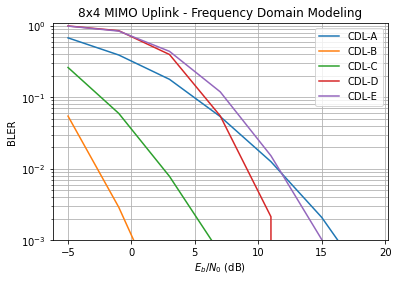

In [32]:
# Load results (un comment to show saved results from the cell above)
#UL_SIMS = eval(" {'ebno_db': [-5.0, -1.0, 3.0, 7.0, 11.0, 15.0, 19.0], 'cdl_model': ['A', 'B', 'C', 'D', 'E'], 'delay_spread': 1e-07, 'domain': 'freq', 'direction': 'uplink', 'perfect_csi': True, 'speed': 0.0, 'cyclic_prefix_length': 6, 'pilot_ofdm_symbol_indices': [2, 11], 'ber': [[0.15734931098090277, 0.08457483362268518, 0.037556287977430554, 0.010201009114583333, 0.0021562364366319443, 0.0004007025824652778, 3.371853298611111e-05], [0.00840893126370614, 0.0004711371527777778, 6.686740451388889e-06, 0.0, 0.0, 0.0, 0.0], [0.05171542697482639, 0.010815988179125817, 0.0012970784505208334, 7.362196180555556e-05, 2.292209201388889e-06, 2.4142795138888887e-06, 0.0], [0.2598809136284722, 0.19302435980902777, 0.07624737774884259, 0.01058502197265625, 0.0003685031467013889, 2.102322048611111e-06, 0.0], [0.25929497612847224, 0.1982150607638889, 0.08891149450231481, 0.021271128713348766, 0.002695751694775132, 0.00017363823784722222, 5.126953125e-06]], 'bler': [[0.65869140625, 0.3756510416666667, 0.18131510416666666, 0.05242598684210526, 0.011625744047619048, 0.00220703125, 0.00017578125], [0.05396792763157895, 0.0032421875, 7.8125e-05, 0.0, 0.0, 0.0, 0.0], [0.26513671875, 0.05962775735294118, 0.007724609375, 0.0005078125, 9.765625e-06, 9.765625e-06, 0.0], [0.986328125, 0.84765625, 0.390625, 0.06243896484375, 0.00248046875, 1.953125e-05, 0.0], [0.98046875, 0.8515625, 0.4348958333333333, 0.115234375, 0.015562996031746032, 0.001083984375, 2.9296875e-05]], 'duration': 679.6544234752655} ")

print("Simulation duration: {:1.2f} [h]".format(UL_SIMS["duration"]/3600))

plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.title("8x4 MIMO Uplink - Frequency Domain Modeling");
plt.ylim([1e-3, 1.1])
legend = []
for i, bler in enumerate(UL_SIMS["bler"]):
    plt.semilogy(UL_SIMS["ebno_db"], bler)
    legend.append("CDL-{}".format(UL_SIMS["cdl_model"][i]))
plt.legend(legend);

### Compare Downlink Performance Over the Different CDL Models <a class="anchor" id="Compare-Downlink-Performance-Over-the-Different-CDL-Models"></a>

We will now compare the downlink performance over the various CDL models assuming perfect CSI at the receiver. 

If you do not want to run the simulation your self, you skip the next cell and visualize the result in the next cell.

In [33]:
DL_SIMS = {
    "ebno_db" : list(np.arange(-5, 20, 4.0)),
    "cdl_model" : ["A", "B", "C", "D", "E"],
    "delay_spread" : 100e-9,
    "domain" : "freq",
    "direction" : "downlink",
    "perfect_csi" : True,
    "speed" : 0.0,
    "cyclic_prefix_length" : 6,
    "pilot_ofdm_symbol_indices" : [2, 11],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

start = time.time()

for cdl_model in DL_SIMS["cdl_model"]:
    
    model = Model(domain=DL_SIMS["domain"],
                  direction=DL_SIMS["direction"],
                  cdl_model=cdl_model,
                  delay_spread=DL_SIMS["delay_spread"],
                  perfect_csi=DL_SIMS["perfect_csi"],
                  speed=DL_SIMS["speed"],
                  cyclic_prefix_length=DL_SIMS["cyclic_prefix_length"],
                  pilot_ofdm_symbol_indices=DL_SIMS["pilot_ofdm_symbol_indices"])
    
    ber, bler = sim_ber(model,
                        DL_SIMS["ebno_db"],
                        batch_size=256,
                        max_mc_iter=100,
                        num_target_block_errors=1000)
    
    DL_SIMS["ber"].append(list(ber.numpy()))
    DL_SIMS["bler"].append(list(bler.numpy()))
    
DL_SIMS["duration"] = time.time() -  start

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.5227e-01 | 9.6191e-01 |      519446 |     1474560 |         1970 |        2048 |        12.5 |reached target block errors
     -1.0 | 2.6469e-01 | 8.3008e-01 |      390294 |     1474560 |         1700 |        2048 |         0.1 |reached target block errors
      3.0 | 1.5529e-01 | 5.5908e-01 |      228982 |     1474560 |         1145 |        2048 |         0.1 |reached target block errors
      7.0 | 7.4751e-02 | 3.0664e-01 |      220451 |     2949120 |         1256 |        4096 |         0.2 |reached target block errors
     11.0 | 2.4375e-02 | 1.1241e-01 |      161742 |     6635520 |         1036 |        9216 |         0.5 |reached target block errors
     15.0 | 6.6249e-03 | 3.3366e-02 |      146532 |    22118400 |

Simulation duration: 0.04 [h]


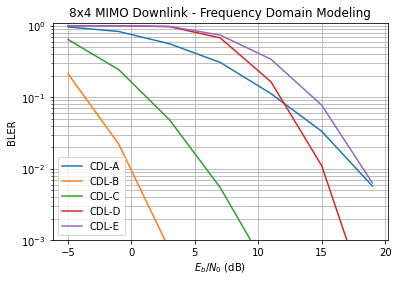

In [34]:
# Load results (uncomment to show saved results from the cell above)
#DL_SIMS = eval(" {'ebno_db': [-5.0, -1.0, 3.0, 7.0, 11.0, 15.0, 19.0], 'cdl_model': ['A', 'B', 'C', 'D', 'E'], 'delay_spread': 1e-07, 'domain': 'freq', 'direction': 'downlink', 'perfect_csi': True, 'speed': 0.0, 'cyclic_prefix_length': 6, 'pilot_ofdm_symbol_indices': [2, 11], 'ber': [[0.3537068684895833, 0.270849609375, 0.15740831163194444, 0.06897718641493056, 0.027840169270833333, 0.0057531419143178105, 0.0009830457899305555], [0.03906005859375, 0.003267002566425121, 7.911512586805555e-05, 2.1158854166666666e-06, 0.0, 0.0, 0.0], [0.16080593532986112, 0.048251139322916664, 0.008695991960152116, 0.0008932291666666666, 4.695638020833333e-05, 3.2416449652777776e-06, 0.0], [0.41819661458333335, 0.37223714192708335, 0.29248792860243056, 0.14547797309027777, 0.025933353484623015, 0.0015725519627700617, 2.2610134548611112e-05], [0.4292819552951389, 0.3885362413194444, 0.30676472981770836, 0.18775770399305555, 0.06542392306857639, 0.01351276625934829, 0.0008977457682291666]], 'bler': [[0.96337890625, 0.84423828125, 0.5703125, 0.287353515625, 0.12337239583333333, 0.028894761029411766, 0.005400390625], [0.2185546875, 0.021505604619565216, 0.000576171875, 9.765625e-06, 0.0, 0.0, 0.0], [0.6484375, 0.2392578125, 0.04682849702380952, 0.0053125, 0.000322265625, 1.953125e-05, 0.0], [1.0, 1.0, 0.9716796875, 0.6572265625, 0.15457589285714285, 0.010883246527777777, 0.000166015625], [1.0, 1.0, 0.9638671875, 0.71240234375, 0.306640625, 0.07647235576923077, 0.0060546875]], 'duration': 558.1218893527985} ")

print("Simulation duration: {:1.2f} [h]".format(DL_SIMS["duration"]/3600))

plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.title("8x4 MIMO Downlink - Frequency Domain Modeling");
plt.ylim([1e-3, 1.1])
legend = []
for i, bler in enumerate(DL_SIMS["bler"]):
    plt.semilogy(DL_SIMS["ebno_db"], bler)
    legend.append("CDL-{}".format(DL_SIMS["cdl_model"][i]))
plt.legend(legend);

### Evaluate the Impact of Mobility <a class="anchor" id="Evaluate-the-Impact-of-Mobility"></a>

Let us now have a look at the impact of the UT speed on the uplink performance.
We compare the scenarios of perfect and imperfect CSI and 0 m/s and 20 m/s speed.
To amplify the detrimental effects of high mobility, we only configure a single
OFDM symbol for pilot transmissions at the beginning of the resource grid.
With perfect CSI, mobility plays hardly any role. However, once channel estimation is 
taken into acount, the BLER saturates.

If you do not want to run the simulation your self, you skip the next cell and visualize the result in the next cell.

In [35]:
MOBILITY_SIMS = {
    "ebno_db" : list(np.arange(0, 32, 2.0)),
    "cdl_model" : "D",
    "delay_spread" : 100e-9,
    "domain" : "freq",
    "direction" : "uplink",
    "perfect_csi" : [True, False],
    "speed" : [0.0, 20.0],
    "cyclic_prefix_length" : 6,
    "pilot_ofdm_symbol_indices" : [0],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

start = time.time()

for perfect_csi in MOBILITY_SIMS["perfect_csi"]:
    for speed in MOBILITY_SIMS["speed"]:
        
        model = Model(domain=MOBILITY_SIMS["domain"],
                  direction=MOBILITY_SIMS["direction"],
                  cdl_model=MOBILITY_SIMS["cdl_model"],
                  delay_spread=MOBILITY_SIMS["delay_spread"],
                  perfect_csi=perfect_csi,
                  speed=speed,
                  cyclic_prefix_length=MOBILITY_SIMS["cyclic_prefix_length"],
                  pilot_ofdm_symbol_indices=MOBILITY_SIMS["pilot_ofdm_symbol_indices"])
    
        ber, bler = sim_ber(model,
                        MOBILITY_SIMS["ebno_db"],
                        batch_size=256,
                        max_mc_iter=100,
                        num_target_block_errors=1000)
    
        MOBILITY_SIMS["ber"].append(list(ber.numpy()))
        MOBILITY_SIMS["bler"].append(list(bler.numpy()))
        
MOBILITY_SIMS["duration"] = time.time() - start        

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6161e-01 | 7.3291e-01 |      258170 |     1597440 |         1501 |        2048 |        12.6 |reached target block errors
      2.0 | 9.3824e-02 | 4.7624e-01 |      224817 |     2396160 |         1463 |        3072 |         0.1 |reached target block errors
      4.0 | 4.4328e-02 | 2.3594e-01 |      177027 |     3993600 |         1208 |        5120 |         0.2 |reached target block errors
      6.0 | 1.5049e-02 | 8.7891e-02 |      144242 |     9584640 |         1080 |       12288 |         0.5 |reached target block errors
      8.0 | 3.4631e-03 | 2.1315e-02 |      127238 |    36741120 |         1004 |       47104 |         2.1 |reached target block errors
     10.0 | 6.0279e-04 | 4.0527e-03 |       48146 |    79872000 |

Simulation duration: 0.04 [h]


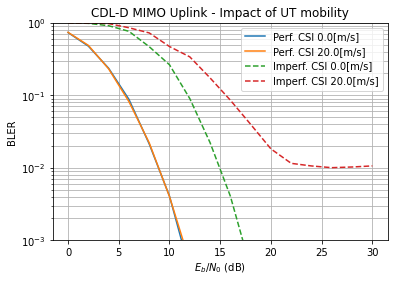

In [36]:
# Load results (uncomment to show saved results from the cell above)
#MOBILITY_SIMS = eval(" {'ebno_db': [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0], 'cdl_model': 'D', 'delay_spread': 1e-07, 'domain': 'freq', 'direction': 'uplink', 'perfect_csi': [True, False], 'speed': [0.0, 20.0], 'cyclic_prefix_length': 6, 'pilot_ofdm_symbol_indices': [0], 'ber': [[0.15169959435096153, 0.10006385216346154, 0.04578732221554487, 0.014152748564369658, 0.003497385589670746, 0.0006175756209935898, 4.672475961538461e-05, 3.342848557692308e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.15599834735576923, 0.09424036792200854, 0.043501602564102564, 0.015064206897702992, 0.0034728119338768115, 0.000610752203525641, 6.844701522435897e-05, 1.4072516025641026e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.27565479767628204, 0.25848482572115383, 0.22961112780448717, 0.16972468449519232, 0.1010475093482906, 0.04783954326923077, 0.016199555652680653, 0.004016548428705441, 0.0006721880008012821, 7.454427083333334e-05, 8.526141826923077e-06, 0.0, 0.0, 0.0, 0.0, 0.0], [0.2835011017628205, 0.2701497395833333, 0.2480888171073718, 0.21193033854166668, 0.16006485376602564, 0.1103377904647436, 0.06517052283653846, 0.0286998781383547, 0.012703033186431624, 0.005103715945512821, 0.0016146116805757136, 0.000522487214110478, 0.00014040694277510683, 4.0696557791435366e-05, 2.5298629981884056e-05, 2.4334147401800328e-05]], 'bler': [[0.708984375, 0.4964192708333333, 0.248046875, 0.08406575520833333, 0.022349964488636364, 0.0041796875, 0.000322265625, 2.9296875e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.71630859375, 0.4788411458333333, 0.237890625, 0.08780924479166667, 0.021739130434782608, 0.004091796875, 0.000556640625, 0.000107421875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9970703125, 0.9765625, 0.92138671875, 0.74755859375, 0.478515625, 0.2455078125, 0.09064275568181818, 0.023890053353658538, 0.00423828125, 0.00052734375, 6.8359375e-05, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9990234375, 0.9931640625, 0.962890625, 0.88232421875, 0.71533203125, 0.5322265625, 0.3470052083333333, 0.16276041666666666, 0.082763671875, 0.0407421875, 0.01862839033018868, 0.012176890432098766, 0.010203043619791666, 0.01010792525773196, 0.010646654211956522, 0.010409740691489361]], 'duration': 705.361558675766} ")

print("Simulation duration: {:1.2f} [h]".format(MOBILITY_SIMS["duration"]/3600))

plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.title("CDL-D MIMO Uplink - Impact of UT mobility")

i = 0
for perfect_csi in MOBILITY_SIMS["perfect_csi"]:
    for speed in MOBILITY_SIMS["speed"]:
        style = "{}".format("-" if perfect_csi else "--")
        s = "{} CSI {}[m/s]".format("Perf." if perfect_csi else "Imperf.", speed)
        plt.semilogy(MOBILITY_SIMS["ebno_db"],
                     MOBILITY_SIMS["bler"][i],
                      style, label=s,)
        i += 1
plt.legend();
plt.ylim([1e-3, 1]);

### Evaluate the Impact of Insufficient Cyclic Prefix Length <a class="anchor" id="Evaluate-the-Impact-of-Insufficient-Cyclic-Prefix-Length"></a>

As a final example, let us have a look at how to simulate OFDM with an insufficiently long cyclic prefix.

It is important to notice, that ISI cannot be simulated in the frequency domain as the [OFDMChannel](https://nvlabs.github.io/sionna/api/channel.html#channel-with-ofdm-waveform) 
implicitly assumes perfectly synchronized and ISI-free transmissions. Having no cyclic
prefix translates simply into an improved Eb/No as no energy for its transmission is used.

Simulating a channel in the time domain requires significantly more memory and compute which
might limit the scenarios for which it can be used.

If you do not want to run the simulation your self, you skip the next cell and visualize the result in the next cell.

In [37]:
CP_SIMS = {
    "ebno_db" : list(np.arange(0, 16, 1.0)),
    "cdl_model" : "C",
    "delay_spread" : 100e-9,
    "subcarrier_spacing" : 15e3,
    "domain" : ["freq", "time"],
    "direction" : "uplink",
    "perfect_csi" : False,
    "speed" : 3.0,
    "cyclic_prefix_length" : [20, 4],
    "pilot_ofdm_symbol_indices" : [2, 11],
    "ber" : [],
    "bler" : [],
    "duration": None
}

start = time.time()

for cyclic_prefix_length in CP_SIMS["cyclic_prefix_length"]:
    for domain in CP_SIMS["domain"]:
        model = Model(domain=domain,
                  direction=CP_SIMS["direction"],
                  cdl_model=CP_SIMS["cdl_model"],
                  delay_spread=CP_SIMS["delay_spread"],
                  perfect_csi=CP_SIMS["perfect_csi"],
                  speed=CP_SIMS["speed"],
                  cyclic_prefix_length=cyclic_prefix_length,
                  pilot_ofdm_symbol_indices=CP_SIMS["pilot_ofdm_symbol_indices"],
                  subcarrier_spacing=CP_SIMS["subcarrier_spacing"])
        
        ber, bler = sim_ber(model,
                        CP_SIMS["ebno_db"],
                        batch_size=256,
                        max_mc_iter=100,
                        num_target_block_errors=1000)
    
        CP_SIMS["ber"].append(list(ber.numpy()))
        CP_SIMS["bler"].append(list(bler.numpy()))
        
CP_SIMS["duration"] = time.time() - start

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.1097e-02 | 3.2300e-01 |      209674 |     2949120 |         1323 |        4096 |        12.5 |reached target block errors
      1.0 | 4.9494e-02 | 2.3516e-01 |      182453 |     3686400 |         1204 |        5120 |         0.2 |reached target block errors
      2.0 | 3.7691e-02 | 1.7497e-01 |      166733 |     4423680 |         1075 |        6144 |         0.3 |reached target block errors
      3.0 | 2.4792e-02 | 1.2012e-01 |      164506 |     6635520 |         1107 |        9216 |         0.4 |reached target block errors
      4.0 | 1.7193e-02 | 8.5449e-02 |      152113 |     8847360 |         1050 |       12288 |         0.5 |reached target block errors
      5.0 | 1.0395e-02 | 5.2375e-02 |      145610 |    14008320 |

Simulation duration: 0.09 [h]


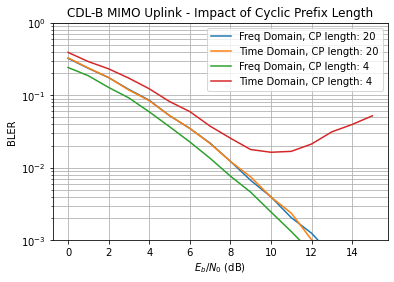

In [38]:
# Load results (uncomment to show saved results from the cell above)
#CP_SIMS = eval(" {'ebno_db': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0], 'cdl_model': 'C', 'delay_spread': 1e-07, 'subcarrier_spacing': 15000.0, 'domain': ['freq', 'time'], 'direction': 'uplink', 'perfect_csi': False, 'speed': 3.0, 'cyclic_prefix_length': [20, 4], 'pilot_ofdm_symbol_indices': [2, 11], 'ber': [[0.06557798032407407, 0.05356038411458333, 0.036498360339506174, 0.02517761752136752, 0.017377266589506172, 0.011118797019675926, 0.006675488753019323, 0.004243488387664524, 0.002491552599862259, 0.0012659071180555555, 0.0007226888020833333, 0.0004105794270833333, 0.00021171875, 0.00011207682291666667, 4.0809461805555556e-05, 2.279730902777778e-05], [0.06876168536324787, 0.051859085648148145, 0.03822603202160494, 0.02548694577991453, 0.016959404550827423, 0.011013454861111112, 0.006892088627304434, 0.004137017877252252, 0.002463582466684675, 0.0014250651041666667, 0.0007145616319444444, 0.00037141927083333336, 0.00019383680555555555, 0.00010481770833333334, 4.1644965277777777e-05, 1.9932725694444446e-05], [0.05217441340488215, 0.03722222222222222, 0.027770973104990583, 0.018300805910669193, 0.012147801143483709, 0.0072280695408950615, 0.004458076408844189, 0.0026281823645104897, 0.0016104890352813088, 0.0008862955729166666, 0.00046706814236111113, 0.0002002495659722222, 0.00011341145833333334, 4.968532986111111e-05, 2.0464409722222224e-05, 1.4811197916666667e-05], [0.0816061000631313, 0.06929166666666667, 0.052485826280381946, 0.035026493778935186, 0.023676058021336554, 0.017314453125, 0.011337403130032207, 0.007286241319444445, 0.004440556877759382, 0.0027163238447260626, 0.0013986585930973266, 0.0009150437801932367, 0.0006104324281090033, 0.00034796381644684255, 0.00018975482723577235, 0.00016822318007662836]], 'bler': [[0.2960069444444444, 0.248046875, 0.17447916666666666, 0.12139423076923077, 0.08697916666666666, 0.05490451388888889, 0.03400135869565218, 0.021543560606060608, 0.012939049586776859, 0.0068515625, 0.0037109375, 0.002203125, 0.001171875, 0.0006171875, 0.000234375, 0.0001171875], [0.3097956730769231, 0.23910984848484848, 0.17604166666666668, 0.12163461538461538, 0.08352726063829788, 0.055182658450704226, 0.03506866591928251, 0.021114864864864864, 0.012662074554294975, 0.0074375, 0.0037265625, 0.0019609375, 0.0010234375, 0.0005703125, 0.0002265625, 0.000109375], [0.24076704545454544, 0.1751736111111111, 0.1340042372881356, 0.08939985795454546, 0.05891682330827068, 0.036205150462962965, 0.022494612068965518, 0.013671875, 0.008275953389830509, 0.0046953125, 0.0024296875, 0.001171875, 0.000609375, 0.00025, 0.000125, 8.59375e-05], [0.37073863636363635, 0.315, 0.246337890625, 0.16438802083333334, 0.1146965579710145, 0.0875, 0.05672554347826087, 0.03807645631067961, 0.025895074503311258, 0.018019153225806453, 0.01474389097744361, 0.016983695652173912, 0.021193258807588076, 0.028158723021582732, 0.038147865853658536, 0.05387931034482758]], 'duration': 5074.19091796875} ")

print("Simulation duration: {:1.2f} [h]".format(CP_SIMS["duration"]/3600))

plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.title("CDL-B MIMO Uplink - Impact of Cyclic Prefix Length")

i = 0
for cyclic_prefix_length in CP_SIMS["cyclic_prefix_length"]:
    for domain in CP_SIMS["domain"]:
        s = "{} Domain, CP length: {}".format("Freq" if domain=="freq" else "Time",
                                               cyclic_prefix_length)
        plt.semilogy(CP_SIMS["ebno_db"],
                     CP_SIMS["bler"][i],
                     label=s)
        i += 1
plt.legend();
plt.ylim([1e-3, 1]);

One can make a few important observations from the figure above:

1. The length of the cyclic prefix has no impact on the performance if
   the system is simulated in the frequency domain.   
   The reason why the two curves for both frequency-domain simulations
   do not overlap is that the cyclic prefix length affects the way the Eb/No is computed.
2. With a sufficiently large cyclic prefix (in our case ``cyclic_prefix_length = 20 >= l_tot = 17`` ), the performance of
   time and frequency-domain simulations are identical.
3. With a too small cyclic prefix length, the performance degrades. At high SNR,  inter-symbol interference 
   (from multiple streams) becomes the dominating source of interference. 